In [44]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano
from scipy import stats as st
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import graphviz
import time
import math
from sklearn.model_selection import train_test_split
from scipy.special import logit

## Data cleaning

In [2]:
nfl = pd.read_csv("nfl_fg.csv")

nfl = nfl.drop("Unnamed: 0", axis=1)

nfl.displayName = nfl.displayName.astype("category")
nfl.homeTeamAbbr = nfl.homeTeamAbbr.astype("category")

nfl = nfl.dropna(subset=["distance"])
nfl = nfl.reset_index()

nfl.seconds = nfl.seconds.astype("float")
# add constant to account for any. 0 values
nfl.seconds = nfl.seconds + 0.001
nfl.seconds = np.log10(nfl.seconds)
nfl.seconds

home_teams = pd.get_dummies(nfl.homeTeamAbbr)
kickers = pd.get_dummies(nfl.displayName)

In [3]:
# standardize

X = nfl[["distance", "seconds", "score_diff"]]
mnX = X.mean().values
stdX = X.std().values
zX = pd.DataFrame(((X - mnX) / stdX).values)

cols = ["distance", "seconds", "diff"]
zX.columns = cols
zX.head()

X = pd.concat([zX, home_teams, kickers], axis=1)
y = nfl["result"]

In [4]:
name = nfl.displayName.values
names = len(nfl.displayName.unique())
name_lookup = dict(zip(nfl.displayName.unique(), range(names)))
name = nfl.displayName.replace(name_lookup).values

distance = nfl.distance.values

stadium = nfl.homeTeamAbbr.values
stadiums = len(nfl.homeTeamAbbr.unique())
stadium_lookup = dict(zip(nfl.homeTeamAbbr.unique(), range(stadiums)))
stadium = nfl.homeTeamAbbr.replace(stadium_lookup).values

In [5]:
X_train, X_test, name_train, name_test, stadium_train, stadium_test, y_train, y_test, distance_train, distance_test = train_test_split(X, name, stadium, y, distance, test_size = 0.33, random_state = 42)

## Bayesian Regression Model

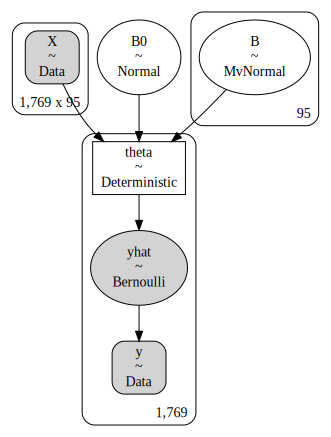

In [6]:
def construct_bayes_regression(model_input, model_output):
    with pm.Model() as bayes_model:
        
        X = pm.Data('X', model_input)
        y = pm.Data('y', model_output)

        B0 = pm.Normal('B0', mu = 0, sd = 1e5)
        B = pm.MvNormal('B', mu = np.zeros(95), cov = np.eye(95) * 1e5, shape = 95)  

        u = B0 + pm.math.dot(X, B)
        theta = pm.Deterministic('theta', pm.invlogit(u))

        yhat = pm.Bernoulli('yhat', p = theta, observed = y)
        
    return bayes_model

bayes_model = construct_bayes_regression(X_train, y_train)
pm.model_to_graphviz(bayes_model)

### Sampling approach

In [7]:
with bayes_model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B, B0]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 104 seconds.
There were 4849 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4938 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4887 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4946 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


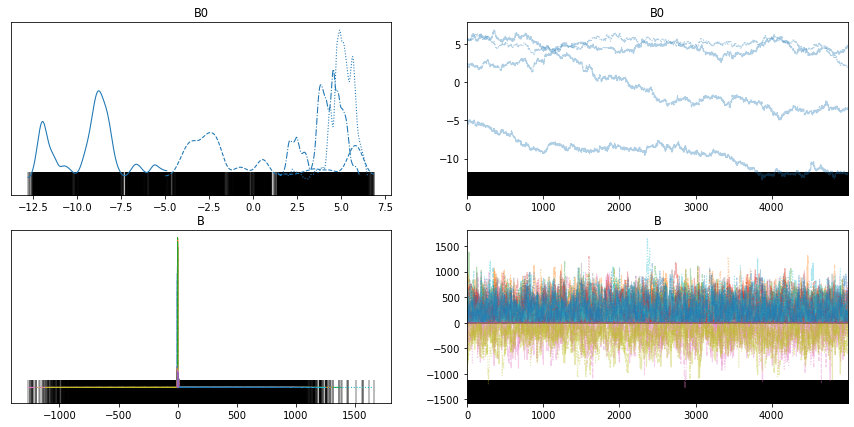

In [8]:
with bayes_model:
    az.plot_trace(trace, var_names=['B0', 'B'], figsize=(15, 7));

In [9]:
with bayes_model:
    print(pm.summary(trace, var_names=['B0', 'B']))

          mean       sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
B0      -0.045    6.030 -11.366    6.328      2.947    2.249       5.0   
B[0]    -1.496    0.106  -1.694   -1.300      0.004    0.003     624.0   
B[1]     0.115    0.077  -0.026    0.259      0.003    0.002     756.0   
B[2]    -0.106    0.081  -0.250    0.054      0.003    0.002     784.0   
B[3]     0.705    4.744  -4.526    9.792      2.318    1.769       5.0   
...        ...      ...     ...      ...        ...      ...       ...   
B[90]  260.224  194.436   1.502  617.394      9.025    6.386     502.0   
B[91]    0.812    1.960  -2.524    4.266      0.776    0.576       7.0   
B[92]    1.284    1.849  -1.542    4.719      0.799    0.599       6.0   
B[93]    1.625    1.899  -1.547    4.994      0.804    0.601       6.0   
B[94]    1.289    1.747  -1.656    4.248      0.758    0.568       6.0   

       ess_tail  r_hat  
B0         12.0   2.11  
B[0]     1320.0   1.01  
B[1]     1043.0   1.00  
B[2]     12

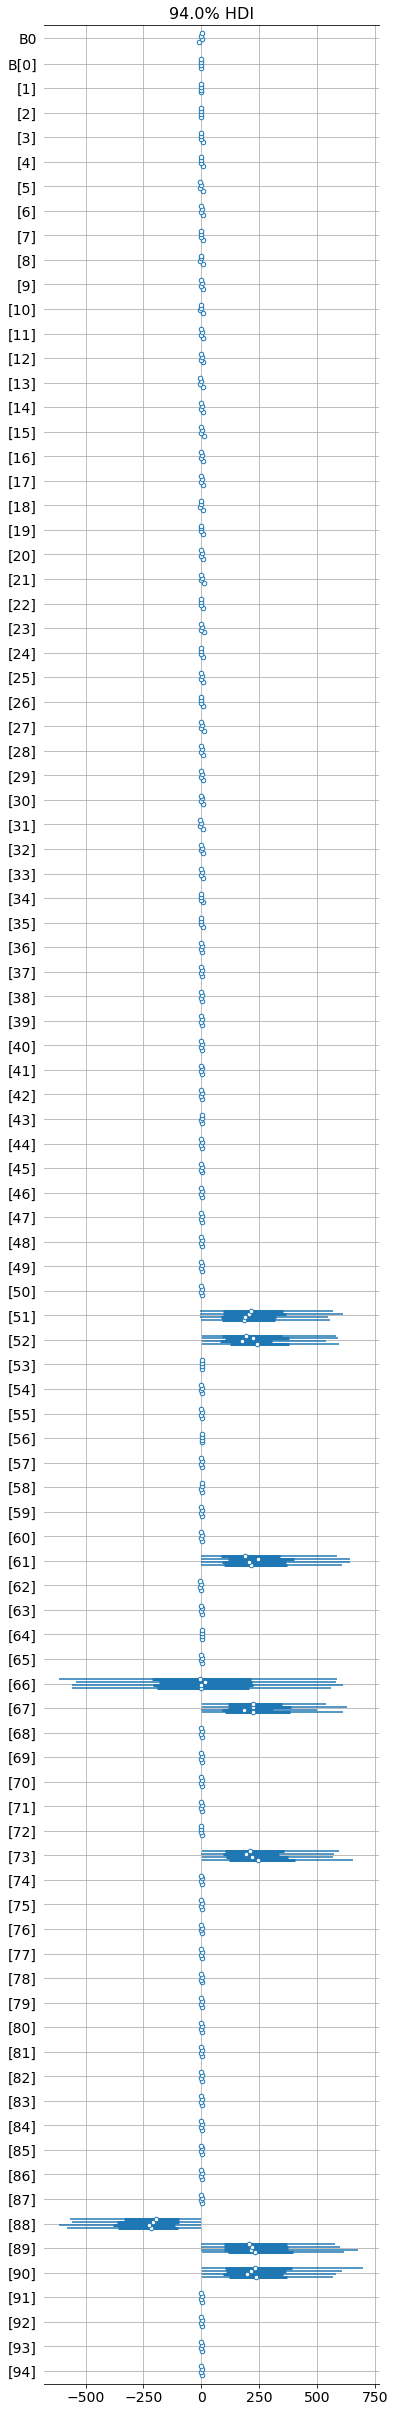

In [10]:
with bayes_model:
    pm.plots.plot_forest(trace, var_names=['B0', 'B'])
    plt.grid()

### Variational approach

Finished [100%]: Average Loss = 1,175.3


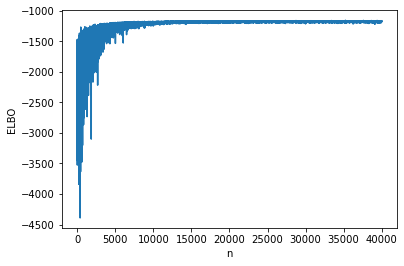

In [11]:
with bayes_model:
    approx = pm.fit(40000, method = 'advi', random_seed = 100)
    sample_advi_reg = approx.sample(1000)

advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [12]:
pm.set_data({'X': X_test, 'y': y_test}, model = bayes_model)

In [13]:
with bayes_model:
    fg_predictions = pm.sample_posterior_predictive(sample_advi_reg, samples=1000, progressbar=False)

yhat = fg_predictions['yhat'].mean(axis=0) > 0.5

In [14]:
print('Accuracy = {}%'.format((y_test == yhat).mean() * 100))

Accuracy = 81.07798165137615%


## Hierarchical Model

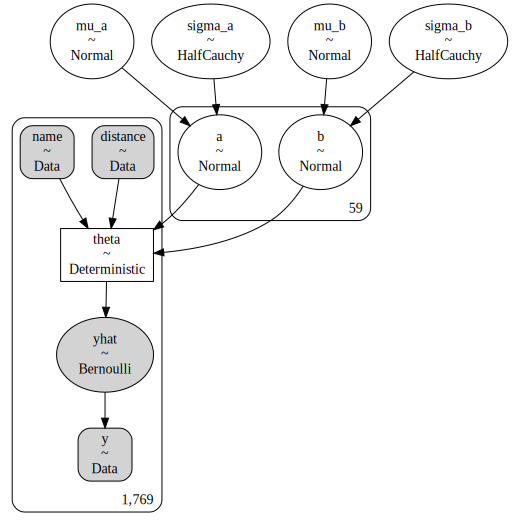

In [15]:
def construct_hierarchical_model(observed, dist, name):
    with pm.Model() as hierarchical_model:

        y = pm.Data("y", observed)
        distance = pm.Data("distance", dist)
        name = pm.Data("name", name_train)

        # priors
        mu_a = pm.Normal("mu_a", mu = 0, sd = 1e5)
        sigma_a = pm.HalfCauchy("sigma_a", 10)
        mu_b = pm.Normal("mu_b", mu = 0, sd = 1e5)
        sigma_b = pm.HalfCauchy("sigma_b", 10)

        # random intercepts
        a = pm.Normal("a", mu = mu_a, sd = sigma_a, shape = names)

        # random slopes
        b = pm.Normal("b", mu = mu_b, sd = sigma_b, shape = names)

        # expected
        u = a[name] + (b[name] * distance)
        theta = pm.Deterministic("theta", pm.invlogit(u))

        yhat = pm.Bernoulli('yhat', p = theta, observed = y)
        
        return hierarchical_model

hierarchical_model = construct_hierarchical_model(y_train, distance_train, name_train)
pm.model_to_graphviz(hierarchical_model)

In [16]:
# with hierarchical_model:
#     hierarchical_trace = pm.sample(5000)

Finished [100%]: Average Loss = 812.41


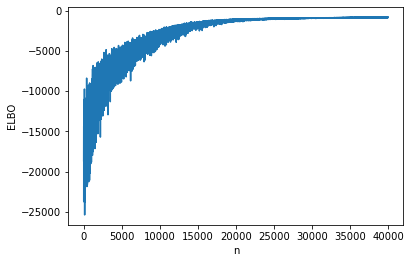

In [17]:
with hierarchical_model:
    approx = pm.fit(40000, method = 'advi', random_seed = 100)
    sample_advi_hi = approx.sample(1000)

advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

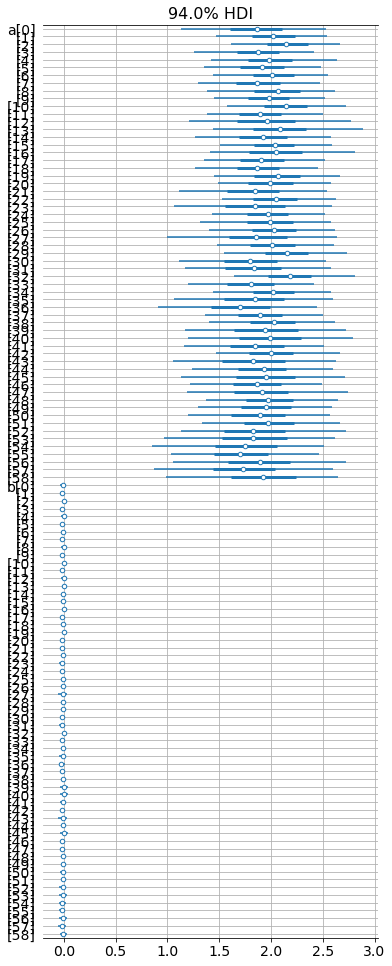

In [18]:
with hierarchical_model:
    pm.plots.plot_forest(sample_advi_hi, var_names=['a', 'b'])
    plt.grid()

In [19]:
pm.set_data({'y': y_test, 'distance': distance_test, 'name': name_test}, model = hierarchical_model)

In [20]:
with hierarchical_model:
    fg_predictions = pm.sample_posterior_predictive(sample_advi_hi, samples=1000, progressbar=False)

yhat = fg_predictions['yhat'].mean(axis=0) > 0.5

In [21]:
print('Accuracy = {}%'.format((y_test == yhat).mean() * 100))

Accuracy = 82.56880733944955%


## Multilevel Model

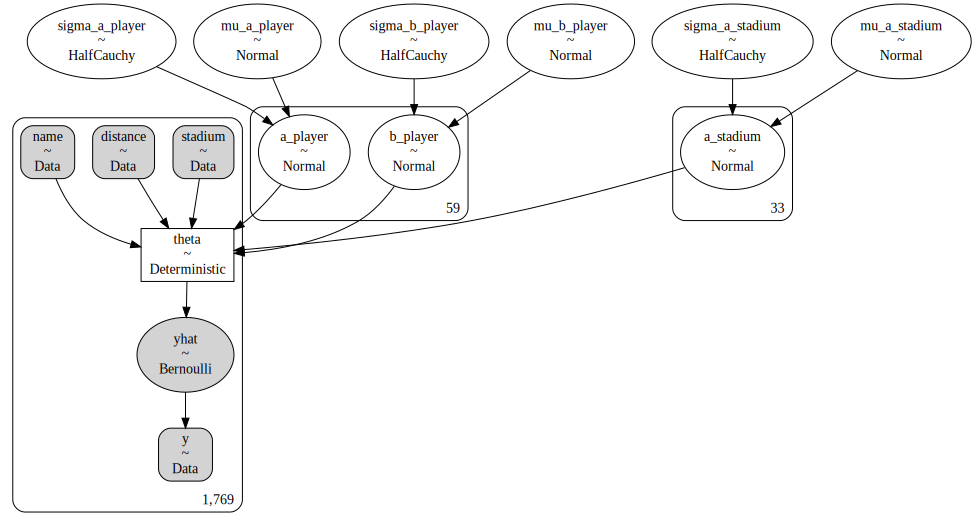

In [22]:
def construct_multilevel_regression(name_input, stadium_input, distance_input, model_output):
    with pm.Model() as multilevel_model:   
        
        name = pm.Data('name', name_input)
        stadium = pm.Data('stadium', stadium_input)
        distance = pm.Data('distance', distance_input)
        y = pm.Data('y', model_output)       

        # priors
        mu_a_player = pm.Normal("mu_a_player", mu = 0, sd = 1e5)
        sigma_a_player = pm.HalfCauchy("sigma_a_player", 10)
        mu_b_player = pm.Normal("mu_b_player", mu = 0, sd = 1e5)
        sigma_b_player = pm.HalfCauchy("sigma_b_player", 10)


        # random intercepts
        a_player = pm.Normal("a_player", mu = mu_a_player, sd = sigma_a_player, shape = names)

        # random slopes
        b_player = pm.Normal("b_player", mu = mu_b_player, sd = sigma_b_player, shape = names)

        # priors
        mu_a_stadium = pm.Normal("mu_a_stadium", mu = 0, sd = 1e5)
        sigma_a_stadium = pm.HalfCauchy("sigma_a_stadium", 10)
        # mu_b_stadium = pm.Normal("mu_b_stadium", mu = 0, sd = 1e5)
        # sigma_b_stadium = pm.HalfCauchy("sigma_b_stadium", 10)

        # random intercepts
        a_stadium = pm.Normal("a_stadium", mu = mu_a_stadium, sd = sigma_a_stadium, shape = stadiums)

        # random slopes
        # b_stadium = pm.Normal("b_stadium", mu = mu_b_stadium, sd = sigma_b_stadium, shape = stadiums)

        u = a_player[name] + (b_player[name] * distance)  + a_stadium[stadium] + (a_stadium[stadium] * a_player[name])


        theta = pm.Deterministic("theta", pm.invlogit(u))

        yhat = pm.Bernoulli('yhat', p = theta, observed = y)
        
    return multilevel_model

multilevel_model = construct_multilevel_regression(name_train, stadium_train, distance_train, y_train)
pm.model_to_graphviz(multilevel_model)

Finished [100%]: Average Loss = 754.65


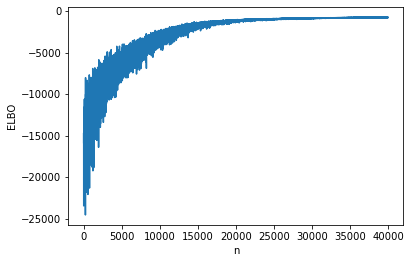

In [23]:
with multilevel_model:
    approx = pm.fit(40000, method = 'advi', random_seed = 100)
    sample_advi_multi = approx.sample(1000)

advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [24]:
pm.set_data({'name': name_test, 
             'stadium': stadium_test, 
             'distance': distance_test, 
             'y': y_test}, 
            model = multilevel_model)  

In [25]:
with multilevel_model:
    fg_predictions = pm.sample_posterior_predictive(sample_advi_multi, samples=1000, progressbar=False)

yhat = fg_predictions['yhat'].mean(axis=0) > 0.5

In [26]:
print('Accuracy = {}%'.format((y_test == yhat).mean() * 100))

Accuracy = 82.33944954128441%


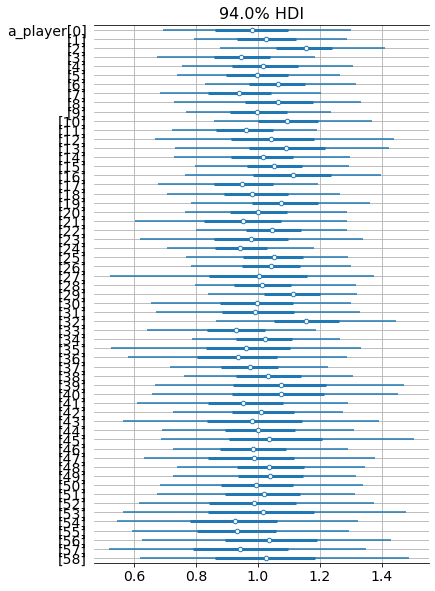

In [27]:
with multilevel_model:
    pm.plots.plot_forest(sample_advi_multi, var_names=['a_player'])
    plt.grid()

## Visualizations

In [35]:
with pm.Model() as h_model:

        # priors
        mu_a = pm.Normal("mu_a", mu = 0, sd = 1e5)
        sigma_a = pm.HalfCauchy("sigma_a", 10)
        mu_b = pm.Normal("mu_b", mu = 0, sd = 1e5)
        sigma_b = pm.HalfCauchy("sigma_b", 10)

        # random intercepts
        a = pm.Normal("a", mu = mu_a, sd = sigma_a, shape = names)

        # random slopes
        b = pm.Normal("b", mu = mu_b, sd = sigma_b, shape = names)

        # expected
        u = a[name] + (b[name] * distance)
        theta = pm.Deterministic("theta", pm.invlogit(u))

        yhat = pm.Bernoulli('yhat', p = theta, observed = y)

In [39]:
with h_model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 124 seconds.
There were 2114 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5351999629826807, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1054 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6763703470414956, but should be close to 0.8. Try to increase the number of tuning steps.
There were 537 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1903 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5265241451448496, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems duri

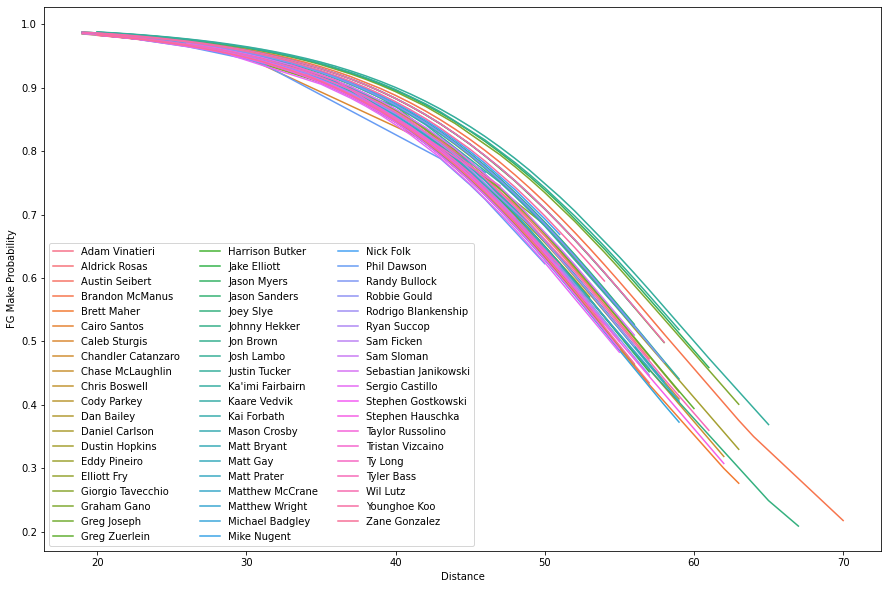

In [56]:
x = np.arange(15, 75)
plt.figure(figsize = (15, 10))
sns.lineplot(x = nfl['distance'], y = trace.theta.mean(axis=0),
               hue = nfl['displayName'])
plt.plot();
plt.xlabel('Distance')
plt.ylabel('FG Make Probability')
plt.legend(ncol = 3)

In [55]:
trace.theta

array([[0.98386034, 0.96718896, 0.68899117, ..., 0.90380742, 0.72943381,
        0.9296135 ],
       [0.98386034, 0.96718896, 0.68899117, ..., 0.90380742, 0.72943381,
        0.9296135 ],
       [0.9845072 , 0.96433887, 0.69508716, ..., 0.90456741, 0.73288827,
        0.9300293 ],
       ...,
       [0.98269082, 0.97232924, 0.60744672, ..., 0.91113796, 0.75011888,
        0.93478441],
       [0.98355432, 0.97154736, 0.63766206, ..., 0.90670493, 0.73545569,
        0.9318453 ],
       [0.98355432, 0.97154736, 0.63766206, ..., 0.90670493, 0.73545569,
        0.9318453 ]])

## WAIC and BMA

In [30]:
cmp_df = az.compare({'hierarchical': sample_advi_hi, 'bayesian regression': sample_advi_reg, 
                     'multilevel': sample_advi_multi}, ic = 'WAIC', 
                    method='BB-pseudo-BMA')
cmp_df

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/jackpeele/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/jackpeele/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/jackpeele/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterio

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
multilevel,0,-423.131205,66.641987,0.000000,9.896677e-01,67.353499,0.000000,True,log
hierarchical,1,-438.416367,43.959875,15.285163,1.033230e-02,20.135406,6.698966,True,log
bayesian regression,2,-572.635193,200.019530,149.503989,9.134183e-23,19.164860,57.205612,True,log


In [31]:
w1 = cmp_df.loc['hierarchical','weight']
w2 = cmp_df.loc['bayesian regression','weight']
w3 = cmp_df.loc['multilevel','weight']
weights = [w1, w2, w3]
y_bma = pm.sample_posterior_predictive_w(traces = [sample_advi_hi, sample_advi_reg, sample_advi_multi],
                                        samples=1000,
                                        models=[hierarchical_model, bayes_model, multilevel_model],
                                        weights=weights)

/Users/jackpeele/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [32]:
# model 1

y_1 = pm.sample_posterior_predictive_w(traces = [sample_advi_hi],
                                        samples=1000,
                                        models=[hierarchical_model])

# model 2

y_2 = pm.sample_posterior_predictive_w(traces = [sample_advi_reg],
                                        samples=1000,
                                        models=[bayes_model])

# model 3

y_3 = pm.sample_posterior_predictive_w(traces = [sample_advi_multi],
                                        samples=1000,
                                        models=[multilevel_model])

ValueError: operands could not be broadcast together with shapes (872,) (2641,) 

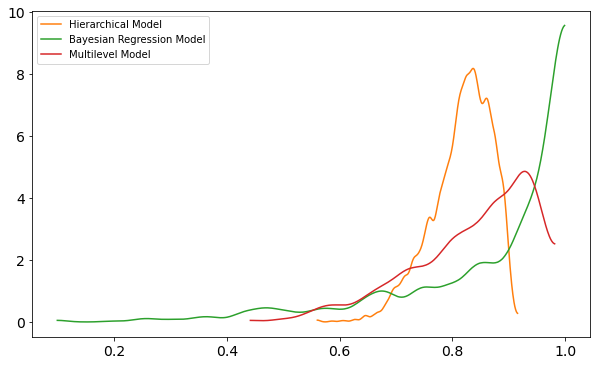

In [33]:
# KDE plots

_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(y_1['yhat'].mean(0), plot_kwargs={'color': 'C1'}, label='Hierarchical Model', ax=ax)
az.plot_kde(y_2['yhat'].mean(0), plot_kwargs={'color': 'C2'}, label='Bayesian Regression Model', ax=ax)
az.plot_kde(y_3['yhat'].mean(0), plot_kwargs={'color': 'C3'}, label='Multilevel Model', ax=ax)
az.plot_kde(y_bma['yhat'].mean(0), plot_kwargs={'color': 'C4'}, label='BMA', ax=ax)

## Unbalanced data

In [ ]:
temp = list(nfl.specialTeamsResult.value_counts())
print(f"{np.round(temp[0]/sum(temp), decimals=2) * 100}% of FG attempts are good in the dataset")

In [ ]:
sns.countplot(x='specialTeamsResult', data=nfl).set_title('Field Goal Results')
plt.show()